# UMC PRE803 Tarea 3: Predicción con IA

*Autores: Jesús Pacheco, Miguelángel Chávez, Samuel Ochoa, Wuilker Álvarez.*

*28/11/2022*

En esta libreta, utilizaremos un [conjunto de datos de enfermedades cardíacas](https://archive.ics.uci.edu/ml/datasets/heart+Disease) proveído por el UCI Machine Learning Repository para construir un modelo de aprendizaje de máquina que permita predecir si un paciente tiene o no alguna enfermedad cardíaca en base a sus características y síntomas.

## Datos originales

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Constantes de utilidad
SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

2022-11-28 18:04:13.620455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Archivo de datos CSV
csv_file = "heart.csv"

In [3]:
# Tabla de datos (dataframe) de Pandas construido a partir del archivo CSV
df = pd.read_csv(csv_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Exploración y preparación de datos

In [4]:
# Mostrar los valores únicos de cada columna
for column in df.columns:
    print(column, list(df[column].unique()), sep="\t")

age	[63, 67, 37, 41, 56, 62, 57, 53, 44, 52, 48, 54, 49, 64, 58, 60, 50, 66, 43, 40, 69, 59, 42, 55, 61, 65, 51, 45, 39, 68, 47, 35, 29, 70, 46, 77, 38, 34, 74, 76, 71]
sex	[1, 0]
cp	[1, 4, 3, 2, 0]
trestbps	[145, 160, 120, 130, 140, 172, 150, 110, 132, 117, 135, 155, 125, 104, 180, 138, 108, 128, 100, 200, 124, 94, 122, 170, 105, 165, 112, 102, 152, 115, 118, 101, 126, 142, 174, 134, 148, 178, 158, 192, 129, 144, 123, 136, 146, 106, 156, 154, 114, 164]
chol	[233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, 256, 263, 199, 168, 239, 275, 266, 211, 283, 284, 224, 206, 219, 340, 226, 247, 167, 230, 335, 234, 177, 276, 353, 243, 225, 269, 267, 248, 197, 360, 258, 308, 245, 270, 208, 264, 321, 274, 325, 235, 257, 302, 164, 231, 141, 252, 255, 183, 330, 222, 217, 282, 288, 220, 209, 227, 261, 213, 174, 281, 198, 221, 205, 309, 240, 289, 318, 298, 265, 564, 246, 322, 299, 300, 293, 277, 304, 214, 207, 160, 249, 394, 212, 184, 315, 409, 244, 305, 195, 196, 273, 126, 313, 259, 200, 2

In [5]:
# Renombrar las columnas para que sean más descriptivas
data = df.rename(
    columns={
        # Edad -- int1
        "age": "age",
        # Sexo -- bool (0 = F, 1 = M)
        "sex": "sex",
        # Tipo de dolor de pecho -- int categórico
        # 1 = Angina de pecho típica
        # 2 = Angina de pecho atípica
        # 3 = Dolor de pecho no anginal
        # 4 = Asintomático (sin dolor de pecho)
        "cp": "chest_pain_type",
        # Presión sanguínea en reposo en mmHg -- int
        "trestbps": "resting_blood_pressure",
        # Colesterol sérico en mg/dl -- int
        "chol": "cholesterol",
        # Azúcar sanguínea en ayuna mayor a 120 mg/dl -- bool
        "fbs": "fasting_blood_sugar_over_120",
        # Resultados electrocardiográficos en reposo -- int categórico
        # 0 = Normal
        # 1 = Presenta anormalidades de segmento ST y/o de onda T
        # 2 = Presenta hipertrofia ventricular izquierda definitiva o probable
        "restecg": "resting_ecg_results",
        # Máxima frecuencia cardíaca alcanzada -- int
        "thalach": "max_heart_rate",
        # Angina de pecho inducida por ejercicio -- bool
        "exang": "exercise_induced_angina",
        # Depresión de ST inducida por ejercicio respecto al reposo -- float
        "oldpeak": "exercise_st_depression",
        # Pendiente del segmento ST más alto durante el ejercicio -- int
        "slope": "peak_exercise_st_slope",
        # Número de vasos sanguíneos mayores coloreados por fluoroscopia 
        # -- int 0-3
        "ca": "major_vessels_colored",
        # Diagnóstico de talasemia (un tipo de anemia hereditaria) 
        # -- string categórico
        # 0 = Normal
        # 1 = Defecto fijo
        # 2 = Defecto reversible
        "thal": "thalassemia",
        # Variable objetivo: Diagnóstico de enfermedad cardíaca -- bool
        "target": "heart_disease_diagnosis"
    }
)

# Normalizar valores de columna thalassemia a enteros
data["thalassemia"] = data["thalassemia"].replace(
    {"normal": 0, "fixed": 1, "reversible": 2, "1": 1, "2": 2}
)

In [6]:
# Verificación
data["thalassemia"].unique()

array([1, 0, 2])

In [7]:
# Información de la nueva tabla de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           303 non-null    int64  
 1   sex                           303 non-null    int64  
 2   chest_pain_type               303 non-null    int64  
 3   resting_blood_pressure        303 non-null    int64  
 4   cholesterol                   303 non-null    int64  
 5   fasting_blood_sugar_over_120  303 non-null    int64  
 6   resting_ecg_results           303 non-null    int64  
 7   max_heart_rate                303 non-null    int64  
 8   exercise_induced_angina       303 non-null    int64  
 9   exercise_st_depression        303 non-null    float64
 10  peak_exercise_st_slope        303 non-null    int64  
 11  major_vessels_colored         303 non-null    int64  
 12  thalassemia                   303 non-null    int64  
 13  heart

In [8]:
# Muestra de 20 pacientes seleccionados aleatoriamente
data.sample(n=20)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar_over_120,resting_ecg_results,max_heart_rate,exercise_induced_angina,exercise_st_depression,peak_exercise_st_slope,major_vessels_colored,thalassemia,heart_disease_diagnosis
14,52,1,3,172,199,1,0,162,0,0.5,1,0,2,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,2,1
202,42,0,3,120,209,0,0,173,0,0.0,2,0,0,0
188,41,0,2,126,306,0,0,163,0,0.0,1,0,0,0
103,64,1,4,120,246,0,2,96,1,2.2,3,1,0,1
302,63,0,4,150,407,0,2,154,0,4.0,2,3,2,1
255,59,1,3,150,212,1,0,157,0,1.6,1,0,0,0
69,35,0,4,138,183,0,0,182,0,1.4,1,0,0,0
280,59,1,4,170,326,0,2,140,1,3.4,3,0,2,1
50,58,1,4,150,270,0,2,111,1,0.8,1,0,2,1


<AxesSubplot:>

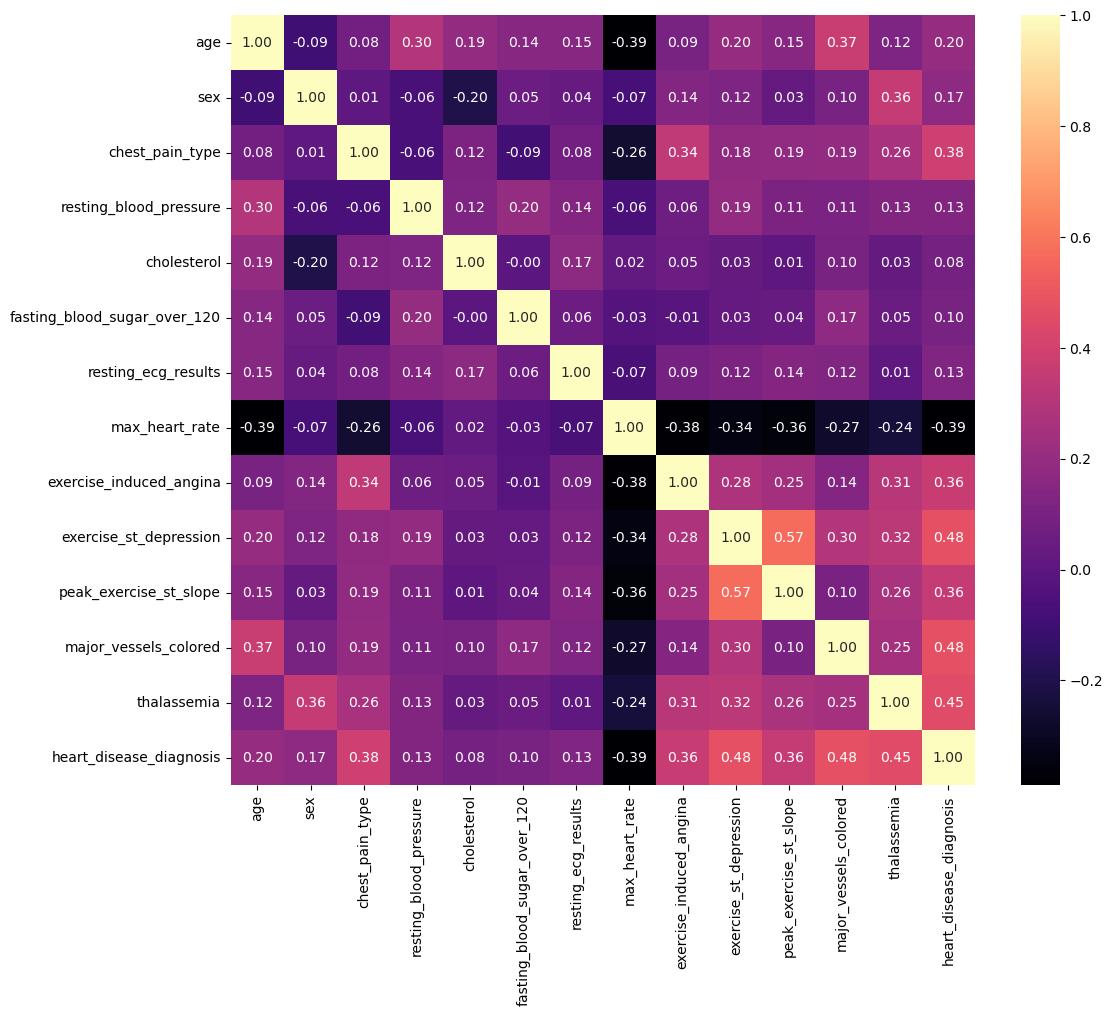

In [9]:
# Visualización de correlación entre variables
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap="magma", fmt='.2f')

## Preprocesamiento de datos

In [10]:
# Separar los datos: 80% para entrenamiento, 20% para pruebas
# Se establece el parámetro random_state para que los resultados 
# sean reproducibles, pero se puede quitar.
test_data = data.sample(frac=0.20, random_state=11)
train_data = data.drop(test_data.index)

# Extraer "etiquetas" de los datos, es decir, la columna objetivo 
# (diagnóstico de enfermedad cardíaca)
test_labels = test_data.pop("heart_disease_diagnosis")
train_labels = train_data.pop("heart_disease_diagnosis")

In [11]:
train_data

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar_over_120,resting_ecg_results,max_heart_rate,exercise_induced_angina,exercise_st_depression,peak_exercise_st_slope,major_vessels_colored,thalassemia
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,1
299,43,0,4,132,341,1,2,136,1,3.0,2,0,2
300,65,1,4,135,254,0,2,127,0,2.8,2,1,2
301,48,1,4,130,256,1,2,150,1,0.0,1,2,2


In [12]:
train_labels

0      0
1      1
3      0
4      0
5      0
      ..
298    0
299    1
300    1
301    1
302    1
Name: heart_disease_diagnosis, Length: 242, dtype: int64

In [13]:
test_data

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar_over_120,resting_ecg_results,max_heart_rate,exercise_induced_angina,exercise_st_depression,peak_exercise_st_slope,major_vessels_colored,thalassemia
207,44,0,3,118,242,0,0,149,0,0.3,2,1,0
12,56,1,3,130,256,1,2,142,1,0.6,2,1,1
282,59,1,4,110,239,0,2,142,1,1.2,2,1,2
297,56,1,4,125,249,1,2,144,1,1.2,2,1,0
60,66,1,4,120,302,0,2,151,0,0.4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,51,1,3,110,175,0,0,123,0,0.6,1,0,0
240,41,1,2,120,157,0,0,182,0,0.0,1,0,0
70,63,1,4,130,330,1,2,132,1,1.8,1,3,2
126,43,1,3,130,315,0,0,162,0,1.9,1,1,0


In [14]:
test_labels

207    0
12     1
282    1
297    0
60     0
      ..
258    0
240    0
70     1
126    0
281    0
Name: heart_disease_diagnosis, Length: 61, dtype: int64

In [15]:
data.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar_over_120', 'resting_ecg_results',
       'max_heart_rate', 'exercise_induced_angina', 'exercise_st_depression',
       'peak_exercise_st_slope', 'major_vessels_colored', 'thalassemia',
       'heart_disease_diagnosis'],
      dtype='object')

In [16]:
# Lista de nombres de columna por tipo de dato

# Valores binarios (0-1)
binary_feature_names = [
    "sex",
    "fasting_blood_sugar_over_120",
    "exercise_induced_angina",
]

# Valores categóricos
categorical_feature_names = [
    "chest_pain_type",
    "resting_ecg_results",
    "thalassemia",
]

# Valores numéricos (punto flotante)
numeric_feature_names = [
    "age",
    "resting_blood_pressure",
    "cholesterol",
    "max_heart_rate",
    "exercise_st_depression",
    "peak_exercise_st_slope",
    "major_vessels_colored",
]

In [17]:
# Crear diccionario asociando cada nombre de columna a una entrada de 
# datos de TensorFlow/Keras con el tipo de datos apropiado
inputs = {}
for name, column in train_data.items():
    if type(column.iloc[0]) == str:
        # Si el primer valor de la columna es una cadena de texto,
        # se usa tipo de dato de cadena de texto
        dtype = tf.string
    elif name in categorical_feature_names or name in binary_feature_names:
        # Si la columna está en la lista de características binarias o 
        # categóricas, se usa tipo de dato entero
        dtype = tf.int64
    else:
        # De lo contrario, se toma como un valor numérico de punto flotante
        dtype = tf.float32
    # Agregar nuevo Input vacío con el nombre de la columna y el tipo de 
    # datos apropiado
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'chest_pain_type': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'chest_pain_type')>,
 'resting_blood_pressure': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'resting_blood_pressure')>,
 'cholesterol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'cholesterol')>,
 'fasting_blood_sugar_over_120': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fasting_blood_sugar_over_120')>,
 'resting_ecg_results': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'resting_ecg_results')>,
 'max_heart_rate': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'max_heart_rate')>,
 'exercise_induced_angina': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exercise_induced_angina')>,
 'exercise_st_depression': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'exercis

In [18]:
# Lista de entradas preprocesadas
preprocessed = []

In [19]:
# Preprocesamiento de entradas binarias

for name in binary_feature_names:
    # Tomar la entrada
    inp = inputs[name]
    # Agregarle un eje nuevo para convertirlo de escalar 
    # a vector (tamaño de lote, profundidad)
    inp = inp[:, tf.newaxis]
    # Convertir el valor de la entrada a tipo decimal
    float_value = tf.cast(inp, tf.float32)
    # Agregar a la lista
    preprocessed.append(float_value)

preprocessed

2022-11-28 18:04:17.474635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 18:04:17.475163: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>]

In [20]:
# Preprocesamiento de entradas numéricas

def stack_dict(inputs, func=tf.stack):
    """
    Construye una pila (stack) a partir del diccionario 
    de datos de entrada dado.
    
    Entradas:
        inputs: Diccionario columna=>Input
        func: Función a aplicar para construir la pila
    
    Retorna:
        Resultado de aplicar la función a la lista de
        valores numéricos de entrada.
    """
    values = []
    for key in sorted(inputs.keys()):
        # Convierte cada valor de entrada a punto flotante
        values.append(tf.cast(inputs[key], tf.float32))
    # Retorna el resultado de aplicar la función a los valores
    return func(values, axis=-1)

# Capa de normalización de valores numéricos
normalizer = tf.keras.layers.Normalization(axis=-1)

# Diccionario de entradas numéricas
numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name] = inputs[name]

# Construye la pila de valores numéricos de entrada
numeric_inputs = stack_dict(numeric_inputs)
# Normaliza los valores numéricos de entrada
numeric_normalized = normalizer(numeric_inputs)

# Agrega las entradas numéricas a la lista de entradas preprocesadas
preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization')>]

In [21]:
# Preprocesamiento de entradas categóricas numéricas y de texto

for name in categorical_feature_names:
    # Construir "vocabulario" para la columna
    # Se trata de una lista de los posibles valores que puede tomar
    vocab = sorted(set(train_data[name]))
    # Mostrar vocabulario de la columna
    print(f"Columna: {name}")
    print(f"Vocabulario: {vocab}\n")
    # Construir capa de conversión de valor categórico a vector 
    # de bits tipo "one-hot". Esto significa que se pasa de una 
    # entrada con n posibles valores a n entradas binarias en 
    # las que un solo valor debe ser 1 y los demás deben ser 0.
    if type(vocab[0]) is str:
        # Si el primer ítem del vocabulario es una cadena de texto, 
        # se crea una capa de conversión para valores de texto
        lookup = tf.keras.layers.StringLookup(
            vocabulary=vocab, output_mode='one_hot'
        )
    else:
        # De lo contrario, se utiliza la capa de conversión 
        # para valores numéricos
        lookup = tf.keras.layers.IntegerLookup(
            vocabulary=vocab, output_mode='one_hot'
        )
    # Tomar la entrada y agregarle un eje para convertirlo 
    # a vector (tamaño de lote, profundidad)
    x = inputs[name][:, tf.newaxis]
    # Aplicarle la capa de conversión a la entrada
    x = lookup(x)
    # Agregar la entrada a la lista de entradas preprocesadas
    preprocessed.append(x)

preprocessed

Columna: chest_pain_type
Vocabulario: [0, 1, 2, 3, 4]

Columna: resting_ecg_results
Vocabulario: [0, 1, 2]

Columna: thalassemia
Vocabulario: [0, 1, 2]



[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>]

In [22]:
# Concatenar las entradas preprocesadas a lo largo de su segundo eje 
# (profundidad), produciendo un solo vector con todas las entradas
preprocessed_result = tf.concat(preprocessed, axis=-1)
preprocessed_result

<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'tf.concat')>

In [23]:
# Construir modelo de preprocesador a partir del resultado anterior 
# para reutilizar el proceso
preprocessor = tf.keras.Model(inputs, preprocessed_result)

In [24]:
# Generar diagrama del modelo de preprocesador
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
# Demostración de funcionamiento de preprocesador 
# con el primer ítem de los datos de entrenamiento
preprocessor(dict(train_data.iloc[:1]))

<tf.Tensor: shape=(1, 24), dtype=float32, numpy=
array([[  1. ,   1. ,   0. ,  63. , 233. ,   2.3,   0. , 150. ,   3. ,
        145. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   1. ,   0. ,   0. ,   1. ,   0. ]], dtype=float32)>

## Construcción y entrenamiento del modelo

In [26]:
# Cuerpo del modelo secuencial
body = tf.keras.Sequential([
    # Capa densa de 20 neuronas
    # Función de activación ReLU (x si x >= 0, 0 si x < 0)
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    tf.keras.layers.Dense(20, activation="relu"),
    # Capa de abandono aleatorio con tasa de 20%:
    # Hace que un 20% de las neuronas, seleccionadas aleatoriamente en cada
    # época, se desactiven
    tf.keras.layers.Dropout(0.2),
    # Capa densa de 40 neuronas, función de activación ReLU
    tf.keras.layers.Dense(40, activation="relu"),
    # Capa de salida de 1 neurona (diagnóstico de enfermedad cardíaca)
    # Función de activación sigmoide 
    # https://en.wikipedia.org/wiki/Sigmoid_function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [27]:
# Entradas
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'chest_pain_type': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'chest_pain_type')>,
 'resting_blood_pressure': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'resting_blood_pressure')>,
 'cholesterol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'cholesterol')>,
 'fasting_blood_sugar_over_120': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fasting_blood_sugar_over_120')>,
 'resting_ecg_results': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'resting_ecg_results')>,
 'max_heart_rate': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'max_heart_rate')>,
 'exercise_induced_angina': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exercise_induced_angina')>,
 'exercise_st_depression': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'exercis

In [28]:
# Preprocesamiento de entradas
# Produce una capa de entrada de 24 neuronas
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'model')>

In [29]:
# Resultado de aplicar las entradas preprocesadas al cuerpo del modelo
# Produce la capa de salida (1 neurona)
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [30]:
# Construcción del modelo completo a partir de las entradas y el resultado
model = tf.keras.Model(inputs, result)
model

In [31]:
# Compilar el modelo
model.compile(
    # Optimizador: Algoritmo Adam con tasa de aprendizaje de 0.001
    # El algoritmo de optimización Adam es un tipo particular de método
    # estocástico de descenso de gradiente. Ajusta los parámetros de las
    # neuronas conforme aprende la red neuronal.
    optimizer=tf.keras.optimizers.Adam(0.001),
    # Función de pérdida: Entropía cruzada binaria
    # Es una función particular de pérdida, es decir que su propósito es
    # calcular el error de clasificación binaria durante cada iteración del
    # entrenamiento. La red tratará de minimizar la pérdida.
    loss=tf.keras.losses.BinaryCrossentropy(),
    # Métrica: Exactitud binaria
    # Calcula la frecuencia con la que las predicciones de la red son
    # correctas, es decir, qué tan frecuentemente determina correctamente 
    # si el diagnóstico de enfermedad cardíaca es positivo o negativo.
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [32]:
# Entrenar el modelo
history = model.fit(
    dict(train_data), train_labels, epochs=100, batch_size=BATCH_SIZE
)

Epoch 1/100
121/121 [==============================] - 1s 5ms/step - loss: 1.5763 - binary_accuracy: 0.6612
Epoch 2/100
121/121 [==============================] - 0s 3ms/step - loss: 0.7963 - binary_accuracy: 0.6942
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6108 - binary_accuracy: 0.7066
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6868 - binary_accuracy: 0.6736
Epoch 5/100
121/121 [==============================] - 0s 3ms/step - loss: 0.5957 - binary_accuracy: 0.7231
Epoch 6/100
121/121 [==============================] - 0s 3ms/step - loss: 0.6609 - binary_accuracy: 0.7231
Epoch 7/100
121/121 [==============================] - 0s 3ms/step - loss: 0.6246 - binary_accuracy: 0.6901
Epoch 8/100
121/121 [==============================] - 0s 3ms/step - loss: 0.6116 - binary_accuracy: 0.7190
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6038 - binary_accuracy: 0.6942
Epoch 10/100
121/121 [======

121/121 [==============================] - 0s 2ms/step - loss: 0.3465 - binary_accuracy: 0.8347
Epoch 77/100
121/121 [==============================] - 0s 3ms/step - loss: 0.3519 - binary_accuracy: 0.8430
Epoch 78/100
121/121 [==============================] - 0s 4ms/step - loss: 0.3264 - binary_accuracy: 0.8554
Epoch 79/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3805 - binary_accuracy: 0.8058
Epoch 80/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3516 - binary_accuracy: 0.8471
Epoch 81/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3287 - binary_accuracy: 0.8636
Epoch 82/100
121/121 [==============================] - 0s 3ms/step - loss: 0.3764 - binary_accuracy: 0.8058
Epoch 83/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3181 - binary_accuracy: 0.8471
Epoch 84/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3306 - binary_accuracy: 0.8554
Epoch 85/100
121/121 [==========

## Evaluación del modelo

In [33]:
model.evaluate(dict(test_data), test_labels, verbose=2)

2/2 - 0s - loss: 0.7566 - binary_accuracy: 0.7869 - 237ms/epoch - 118ms/step


[0.7565971612930298, 0.7868852615356445]

## Diagnóstico interactivo

A continuación, se implementa una interfaz interactiva de texto simple para tomar los datos de entrada del usuario y usarlos con el modelo para producir la predicción de si el paciente tiene una enfermedad cardíaca o no.

In [34]:
def ingresar_entero_positivo(texto) -> int:
    """Pide entrada al usuario hasta que ingrese un entero positivo."""
    val = None
    texto_error = "Debe ingresar un número entero positivo."
    while val is None:
        try:
            val = int(input(texto + " "))
        except ValueError:
            print(f"ERROR: {texto_error}")
        else:
            if val <= 0:
                print(f"ERROR: {texto_error}")
                val = None
    return val


def ingresar_opcion(texto, opciones, func=str) -> int:
    """Pide entrada al usuario hasta que ingrese una opción de la lista dada."""
    val = None
    while val is None:
        try:
            val = opciones.index(func(input(texto + " ")))
        except ValueError:
            print("ERROR: Opción no válida")
    return val


def ingresar_entero_rango(texto, min_val, max_val) -> int:
    """Pide entrada al usuario hasta que ingrese un entero en el rango dado."""
    val = None
    texto_error = f"Debe ingresar un número entero entre {min_val} y {max_val}."
    while val is None:
        try:
            val = int(input(texto + " "))
        except ValueError:
            print(f"ERROR: {texto_error}")
        else:
            if val not in range(min_val, max_val + 1):
                print(f"ERROR: {texto_error}")
                val = None
    return val


def ingresar_decimal_positivo(texto) -> float:
    """Pide entrada al usuario hasta que ingrese un decimal positivo."""
    val = None
    texto_error = "Debe ingresar un número decimal positivo."
    while val is None:
        try:
            val = float(input(texto + " "))
        except ValueError:
            print(f"ERROR: {texto_error}")
        else:
            if val <= 0:
                print(f"ERROR: {texto_error}")
                val = None
    return val


def diagnosticar(modelo, datos_dict) -> bool:
    """Retorna la predicción realizada con el modelo y los datos dados."""
    # Convertir valores de diccionario a series de Pandas
    for k in datos_dict:
        datos_dict[k] = pd.Series(datos_dict[k])
    # Realizar predicción con el modelo
    prediccion = modelo.predict(datos_dict)[0][0]
    print(prediccion)
    # Redondear predicción a 0 o a 1, convertir a booleano y retornar resultado
    return bool(round(prediccion))


def diagnostico_interactivo(modelo):
    """
    Permite al usuario ingresar los datos del paciente y muestra su diagnóstico.
    """
    datos_dict = {}
    print(":: DIANÓSTICO INTERACTIVO DE ENFERMEDAD CARDÍACA ::")
    print("Ingrese los datos del paciente que se le solicite a continuación.")
    print()
    # Edad
    datos_dict["age"] = ingresar_entero_positivo("Edad:")
    print()
    # Sexo
    datos_dict["sex"] = ingresar_opcion(
        "Sexo [F / M]:", ["F", "M"], func=lambda x: str(x).upper()
    )
    print()
    # Tipo de dolor de pecho
    print("Tipo de dolor de pecho:")
    print("1) Angina de pecho típica")
    print("2) Angina de pecho atípica")
    print("3) Dolor de pecho no anginal")
    print("4) Asintomático (sin dolor de pecho)")
    datos_dict["chest_pain_type"] = ingresar_entero_rango(
        "Ingrese el número de opción correspondiente [1-4]:", 1, 4
    )
    print()
    # Presión sanguínea en reposo en mmHg
    datos_dict["resting_blood_pressure"] = ingresar_entero_positivo(
        "Presión sanguínea en reposo (mmHg):"
    )
    print()
    # Colesterol sérico en mg/dl
    datos_dict["cholesterol"] = ingresar_entero_positivo(
        "Colesterol sérico (mg/dl):"
    )
    print()
    # Azúcar sanguínea en ayuna mayor a 120 mg/dl
    fbs = ingresar_entero_positivo("Azúcar sanguínea en ayuna (mg/dl):")
    datos_dict["fasting_blood_sugar_over_120"] = fbs >= 120
    print()
    # Resultados electrocardiográficos en reposo
    print("Resultados electrocardiográficos en reposo:")
    print("0) Normal")
    print("1) Presenta anormalidades de segmento ST y/o de onda T")
    print("2) Presenta hipertrofia ventricular izquierda definitiva o probable")
    datos_dict["resting_ecg_results"] = ingresar_entero_rango(
        "Ingrese el número de opción correspondiente [0-2]:", 0, 2
    )
    print()
    # Máxima frecuencia cardíaca alcanzada
    datos_dict["max_heart_rate"] = ingresar_entero_positivo(
        "Máxima frecuencia cardíaca alcanzada:"
    )
    print()
    # Angina de pecho inducida por ejercicio
    datos_dict["exercise_induced_angina"] = ingresar_opcion(
        "¿Angina de pecho inducida por ejercicio? Sí o no [s / n]:",
        ["N", "S"],
        func=lambda x: str(x).upper(),
    )
    print()
    # Depresión de ST inducida por ejercicio respecto al reposo
    datos_dict["exercise_st_depression"] = ingresar_decimal_positivo(
        "Depresión de ST inducida por ejercicio respecto al reposo "
        "(decimal positivo):"
    )
    print()
    # Pendiente del segmento ST más alto durante el ejercicio
    datos_dict["peak_exercise_st_slope"] = ingresar_entero_rango(
        "Pendiente del segmento ST más alto durante el ejercicio [1-3]:", 1, 3
    )
    print()
    # Número de vasos sanguíneos mayores coloreados por fluoroscopia
    datos_dict["major_vessels_colored"] = ingresar_entero_rango(
        "Número de vasos sanguíneos mayores coloreados por fluoroscopia [0-3]:",
        0,
        3,
    )
    print()
    # Diagnóstico de talasemia
    print("Diagnóstico de talasemia:")
    print("0) Normal")
    print("1) Defecto fijo")
    print("2) Defecto reversible")
    datos_dict["thalassemia"] = ingresar_entero_rango(
        "Ingrese el número de opción correspondiente [0-2]:", 0, 2
    )
    print()
    # Realizar diagnóstico y mostrar resultado
    print("Realizando predicción...")
    resultado = diagnosticar(modelo, datos_dict)
    resultado_str = "POSITIVO" if resultado else "NEGATIVO"
    print()
    print(f"RESULTADO: {resultado_str} PARA ENFERMEDAD CARDÍACA")

In [35]:
# Datos de un paciente aleatorio diagnosticado positivo y otro negativo 
# como ejemplos para los datos a ingresar
examples = pd.concat(
    [
        data[data.heart_disease_diagnosis == 0].sample(1),
        data[data.heart_disease_diagnosis == 1].sample(1),
    ],
    axis=0,
)

examples.T

,145,245
age,50.0,57.0
sex,0.0,1.0
chest_pain_type,2.0,4.0
resting_blood_pressure,120.0,130.0
cholesterol,244.0,131.0
fasting_blood_sugar_over_120,0.0,0.0
resting_ecg_results,0.0,0.0
max_heart_rate,162.0,115.0
exercise_induced_angina,0.0,1.0
exercise_st_depression,1.1,1.2


In [36]:
diagnostico_interactivo(model)

:: DIANÓSTICO INTERACTIVO DE ENFERMEDAD CARDÍACA ::
Ingrese los datos del paciente que se le solicite a continuación.

Edad: 69

Sexo [F / M]: m

Tipo de dolor de pecho:
1) Angina de pecho típica
2) Angina de pecho atípica
3) Dolor de pecho no anginal
4) Asintomático (sin dolor de pecho)
Ingrese el número de opción correspondiente [1-4]: 4

Presión sanguínea en reposo (mmHg): 135

Colesterol sérico (mg/dl): 277

Azúcar sanguínea en ayuna (mg/dl): 120

Resultados electrocardiográficos en reposo:
0) Normal
1) Presenta anormalidades de segmento ST y/o de onda T
2) Presenta hipertrofia ventricular izquierda definitiva o probable
Ingrese el número de opción correspondiente [0-2]: 2

Máxima frecuencia cardíaca alcanzada: 142

¿Angina de pecho inducida por ejercicio? Sí o no [s / n]: s

Depresión de ST inducida por ejercicio respecto al reposo (decimal positivo): 1.5

Pendiente del segmento ST más alto durante el ejercicio [1-3]: 2

Número de vasos sanguíneos mayores coloreados por fluoroscop